In [1]:
import os
import mysql.connector as connection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import simplekml
from haversine import haversine, Unit
from sqlalchemy import create_engine
from sqlalchemy import text as sql_text

In [2]:
# Access environment variables
host = os.environ.get("MYSQL_HOST", "mysql")  # Default to "mysql" if not set
port = int(os.environ.get("MYSQL_PORT", 3306)) # Default to 3306
user = os.environ.get("MYSQL_USER", "root")
password = os.environ.get("MYSQL_PASSWORD") 
database = os.environ.get("MYSQL_DATABASE")

In [3]:
base_date_start = '2022-07-25'
base_date_end = '2022-07-29'

In [4]:
engine_uri = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}"
connection = create_engine(engine_uri)

query_fat_events = f"""
    SELECT fat_event.*
    FROM fat_event
    INNER JOIN dim_line ON dim_line.id = fat_event.dim_line_id
    INNER JOIN fat_most_relevant_itinerary AS fat_mri ON
    	fat_mri.line_code = dim_line.line_code AND 
        fat_mri.itinerary_id = fat_event.itinerary_id AND
        fat_mri.base_date = fat_event.base_date
    WHERE
    	fat_event.base_date BETWEEN '{base_date_start}' AND '{base_date_end}'
"""

query_dim_bus_stops = f"""
    SELECT 
    	*,
    	CASE 
    		WHEN type_norm LIKE 'Bus Terminal' THEN 
    			DENSE_RANK() OVER (ORDER BY name_norm) - 1
    		ELSE
    			legacy_id
    	END AS dummy_id
    FROM dim_bus_stop
"""

query_dim_lines = f"""
    SELECT *
    FROM dim_line
"""

fat_events = pd.read_sql_query(sql_text(query_fat_events), connection.connect())
dim_bus_stops = pd.read_sql_query(sql_text(query_dim_bus_stops), connection.connect())
dim_lines = pd.read_sql_query(sql_text(query_dim_lines), connection.connect())

In [5]:
logs = pd.merge(
    fat_events[['dim_line_id', 'vehicle', 'itinerary_id', 'event_timestamp', 'seq', 'dim_bus_stop_id', 'base_date']], 
    dim_bus_stops[['id', 'dummy_id']], 
    left_on = 'dim_bus_stop_id', 
    right_on = 'id', 
    how = 'inner'
).drop(
    "id",
    axis = 1
).merge(
    dim_lines[["id", "line_code"]],
    left_on = 'dim_line_id', 
    right_on = 'id', 
    how = 'inner'
).drop(
    "id",
    axis = 1
)

In [6]:
grouped = logs.sort_values(by = 'event_timestamp').groupby(['dummy_id', 'base_date'])

In [7]:
df_bus_availability = grouped.rolling(
    window = "10min", min_periods = 1, on = "event_timestamp", closed = "both"
).agg(
     {'vehicle': 'count'}
).reset_index()

In [8]:
dim_bs = dim_bus_stops.groupby(by = ['dummy_id', 'name_norm', 'type_norm']).agg(
    {
        'latitude': 'mean',
        'longitude': 'mean'
    }
).reset_index()

# Mapping dictionary for replacing values
mapping = {
    "Bus terminal": "Terminal",
    "Street bus stop": "Ponto de rua",
    "Tube station": "Estação tubo"
}

# Replacing values in the 'type_norm' column
dim_bs['type_norm'] = dim_bs['type_norm'].map(mapping)
df_bus_availability['hour'] = df_bus_availability.event_timestamp.dt.hour
df_bus_availability.query('hour not in [0,1,2,3,4]', inplace = True)
df_bus_availability = pd.merge(df_bus_availability, dim_bs)

# Average number of vehicles aggregated per hour
df_bus_availability = df_bus_availability.groupby(by = ['dummy_id','name_norm','type_norm','hour']).agg(
    {
        'vehicle': 'mean'
    }
).reset_index()

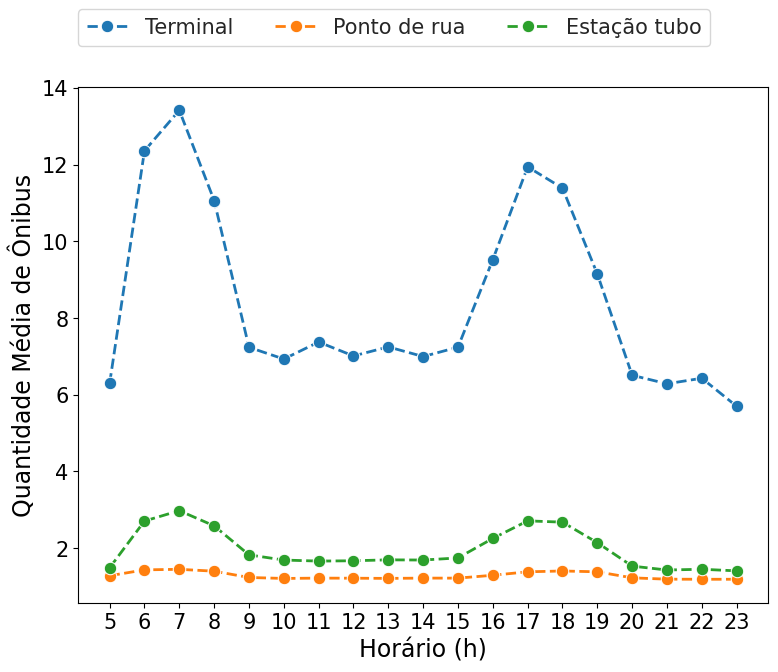

In [9]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.hour, y = df_bus_availability.vehicle, estimator='mean', err_style = None, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = df_bus_availability.type_norm, hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], palette = sns.color_palette("tab10", 3), ax = axes)
g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Horário (h)", fontsize = 17)
g.set_ylabel("Quantidade Média de Ônibus", fontsize = 17)
plt.savefig('bus_availability.png', format='png', dpi=300);

In [10]:
df_bus_availability_day = df_bus_availability.groupby(by = ['dummy_id','name_norm','type_norm']).agg(
    {
        'vehicle': 'mean'
    }
).reset_index()

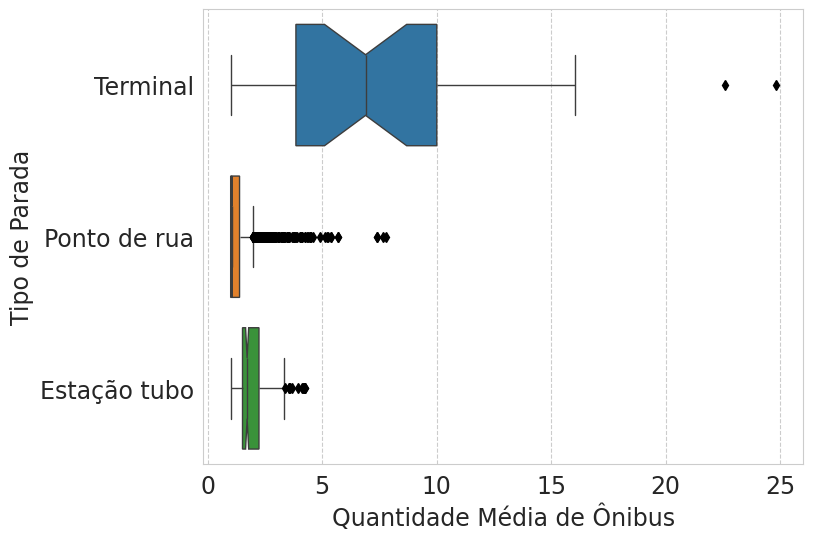

In [11]:
fig, axes = plt.subplots(figsize = (10, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(x = df_bus_availability_day.vehicle, y = df_bus_availability_day.type_norm, linewidth = 1.0, hue = df_bus_availability_day.type_norm, palette = sns.color_palette("tab10", 3), notch = True, order = ['Terminal', 'Ponto de rua', 'Estação tubo'], hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 17)
g.set_xlabel("Quantidade Média de Ônibus", fontsize = 17)
g.set_ylabel("Tipo de Parada", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('daily_avg_bus_availability.png', format='png', dpi=300)

In [12]:
# Select only bus stops and tube stations located on the street
df_bus_availability_day.query(r"type_norm != 'Terminal'", inplace = True)

In [13]:
stat = df_bus_availability_day.vehicle.describe().to_frame().transpose()

In [14]:
stat

,count,mean,std,min,25%,50%,75%,max
vehicle,6166.0,1.300396,0.510012,1.0,1.0,1.06938,1.42729,7.790009


In [15]:
# Identify and select outliers: defined as values greater than Q3 + 1.5 * IQR
out = stat["75%"] + 1.5 * (stat["75%"] - stat["25%"])
top = df_bus_availability_day.query(f"vehicle >= {out.vehicle}")

In [16]:
top.sort_values('vehicle', ascending = False)

,dummy_id,name_norm,type_norm,vehicle
3276,150751.0,"Av. Winston Churchill, 2677 - Capão Raso",Ponto de rua,7.790009
2946,150330.0,"Av. Winston Churchill, 2546 - Capão Raso",Ponto de rua,7.676886
2948,150332.0,"Rua Léon Nicolas, 2081 - Capão Raso",Ponto de rua,7.386017
2947,150331.0,"Av. Winston Churchill, 2472 - Capão Raso",Ponto de rua,7.373234
3450,160072.0,"Rodovia BR476, 21283 - Cidade Industrial",Ponto de rua,5.682305
...,...,...,...,...
2754,150106.0,"Av. Brasília, 6105 - Novo Mundo",Ponto de rua,2.079290
3462,160085.0,"Rua Lupionopolis, 1157 - Sítio Cercado",Ponto de rua,2.076460
4637,180072.0,"Rua Benjamin Lins, 25 - Batel",Ponto de rua,2.076087
472,110106.0,"Alameda Dr. Carlos de Carvalho, 158 - Centro",Ponto de rua,2.069582


In [17]:
top = pd.merge(top, dim_bus_stops[['legacy_id', 'dummy_id']])

In [18]:
cluster_centroids = top.sort_values(by = "vehicle", ascending = False).dummy_id.to_list()

In [19]:
merge_df = dim_bs.query(
    f"dummy_id == {cluster_centroids[0]}"
).merge(
    dim_bs,
    how = "cross"
)
merge_df['d'] = merge_df.apply(
    lambda row: haversine(
        (row["latitude_x"], row["longitude_x"]), (row["latitude_y"], row["longitude_y"]),
        unit = Unit.METERS),
    axis = 1
)
merge_df['centre'] = np.where(merge_df['dummy_id_x'] == merge_df['dummy_id_y'], 1, 0)
merge_df.query(
    "d <= 600"
)[['dummy_id_y', 'centre']].rename(
    columns = {'dummy_id_y': 'dummy_id'}
)

,dummy_id,centre
250,108123.0,0
251,108124.0,0
3132,150270.0,0
3133,150271.0,0
3134,150272.0,0
3191,150330.0,0
3192,150331.0,0
3194,150334.0,0
3547,150751.0,1
3599,150827.0,0


In [20]:
# Build the clusters from the outliers
cluster_centroids = top.sort_values(by = "vehicle", ascending = False).dummy_id.to_list()
clusters = []
dummy_ids = []
c = 0
while len(cluster_centroids) > 0:
    merge_df = dim_bs.query(
        f"dummy_id == {cluster_centroids[0]}"
    ).merge(
        dim_bs,
        how = "cross"
    )
    merge_df['d'] = merge_df.apply(
        lambda row: haversine(
            (row["latitude_x"], row["longitude_x"]), (row["latitude_y"], row["longitude_y"]),
            unit = Unit.METERS),
        axis = 1
    )
    merge_df['centre'] = np.where(merge_df['dummy_id_x'] == merge_df['dummy_id_y'], 1, 0)
    cluster = merge_df.query(
        "d <= 600"
    )[['dummy_id_y', 'centre']].rename(
        columns = {'dummy_id_y': 'dummy_id'}
    )
    cluster["cluster"] = c
    clusters.append(cluster)
    for item in cluster.dummy_id.to_list():        
        if item in cluster_centroids:
            cluster_centroids.remove(item)    
    cluster.query("dummy_id not in @dummy_ids", inplace = True)
    dummy_ids.extend(cluster.dummy_id.to_list())
    dummy_ids = list(dict.fromkeys(dummy_ids))    
    c = c + 1
    print(len(cluster_centroids))
clusters = pd.concat(clusters, ignore_index = True)

409
408
404
397
391
379
377
362
353
348
344
338
331
323
311
302
297
291
282
277
269
265
264
263
258
251
244
239
233
230
225
222
217
214
211
208
207
204
203
202
198
192
190
189
187
185
178
174
170
169
168
162
160
159
152
150
145
141
140
133
130
128
125
123
122
120
113
107
102
100
95
93
88
86
85
82
81
80
78
77
76
72
70
68
64
58
56
52
51
50
48
42
38
32
29
24
22
21
15
14
12
10
9
7
5
3
2
1
0


In [21]:
# Build bus stop pairs from the clusters
all_pairs = []
for cluster in clusters.cluster.unique():
    pairs = clusters.query(f"cluster == {cluster}")[["dummy_id"]].merge(
        clusters.query(f"cluster == {cluster}")[["dummy_id"]], how = "cross"
    )
    pairs = pairs.merge(
        dim_bs[["dummy_id", "latitude", "longitude"]],
        left_on = "dummy_id_x",
        right_on = "dummy_id"
    ).drop(
        "dummy_id",
        axis = 1
    ).merge(
        dim_bs[["dummy_id", "latitude", "longitude"]],
        left_on = "dummy_id_y",
        right_on = "dummy_id"
    ).drop(
        "dummy_id",
        axis = 1
    )    
    pairs["dist"] = pairs.apply(
        lambda row: haversine(
            (row["latitude_x"], row["longitude_x"]), (row["latitude_y"], row["longitude_y"]),
            unit = Unit.METERS),
        axis = 1
    )
    pairs["cluster"] = cluster
    all_pairs.append(pairs)
all_pairs = pd.concat(all_pairs, ignore_index = True)
all_pairs.query("dist <= 600", inplace = True)

In [22]:
# Saving the files needed to do the connections searching
output_dir = f"{base_date_start}_to_{base_date_end}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
fat_events.to_parquet(f"{output_dir}//fat_events.parquet")
dim_bus_stops.to_parquet(f"{output_dir}//dim_bus_stops.parquet")
logs.to_parquet(f"{output_dir}//logs.parquet")
dim_bs.to_parquet(f"{output_dir}//dim_bs.parquet")
clusters.to_parquet(f"{output_dir}//clusters.parquet")
all_pairs.to_parquet(f"{output_dir}//all_pairs.parquet")